In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from transformers import BertTokenizer

# Load tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')  # or the model name you fine-tuned from

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [2]:
#load the model
model = tf.saved_model.load("/kaggle/input/src-of/sentiment_model")

In [9]:
#load the dataset
dft = pd.read_csv('/kaggle/input/birdyfinal/test.csv')

In [10]:
classes = [
    'Cyber Bullying  Stalking  Sexting',
    'Fraud CallVishing',
    'UPI Related Frauds',
    'FakeImpersonating Profile',
    'Profile Hacking Identity Theft',
    'Other',
    'Provocative Speech for unlawful acts',
    'EWallet Related Fraud',
    'DebitCredit Card FraudSim Swap Fraud',
    'Internet Banking Related Fraud',
    'Sexually Explicit Act',
    'Data Breach/Theft',
    'Unauthorised AccessData Breach',
    'Cheating by Impersonation',
    'Website DefacementHacking',
    'Cryptocurrency Fraud',
    'RapeGang Rape RGRSexually Abusive Content',
    'Malware Attack',
    'SQL Injection',
    'Online Job Fraud',
    'Email Hacking',
    'Sexually Obscene material',
    'Online Gambling  Betting',
    'DematDepository Fraud',
    'Hacking/Defacement',
    'EMail Phishing',
    'Tampering with computer source documents',
    'Cyber Terrorism',
    'Ransomware Attack',
    'Online Trafficking',
    'Child Pornography CPChild Sexual Abuse Material CSAM',
    'Damage to computer computer systems etc',
    'Online Matrimonial Fraud',
    'Denial of Service (DoS)/Distributed Denial of Service (DDOS) attacks',
    'Ransomware',
    'Business Email CompromiseEmail Takeover',
    'Impersonating Email',
    'Intimidating Email',
    'Against Interest of sovereignty or integrity of India'
]
label2id = {label: idx for idx, label in enumerate(classes)}
id2label = {idx: label for idx, label in enumerate(classes)}


In [11]:
# Prepare the data for prediction
def prepare_data(input_text, tokenizer):
    token = tokenizer.encode_plus(
        input_text,
        max_length=256, 
        truncation=True, 
        padding='max_length', 
        add_special_tokens=True,
        return_tensors='tf'
    )
    return {
        'input_ids': tf.cast(token['input_ids'], tf.int32),
        'attention_mask': tf.cast(token['attention_mask'], tf.int32)
    }

# Make predictions with the model
def make_prediction(model, processed_data):
    predict_fn = model.signatures["serving_default"]
    output = predict_fn(input_ids=processed_data['input_ids'], attention_mask=processed_data['attention_mask'])
    
    if 'output_layer' in output:
        probs = output['output_layer'].numpy()
    else:
        raise KeyError("Expected key 'output_layer' not found in output")
    
    return np.argmax(probs, axis=1)[0]  # Return the predicted class (single value)


In [12]:
dft = dft.dropna(subset=['crimeaditionalinfo'])
dft['sub_category'] = dft['sub_category'].fillna(dft['category'])
dft = dft.sample(frac=1.0, random_state=42)
dft["labels"] = dft['sub_category'].map(lambda x: label2id.get(x.strip(), 1))  # Default to 1 if not found

Processing rows:   0%|          | 0/31222 [00:00<?, ?it/s]

Accuracy: 0.6
Precision: 0.5835563063063064
Recall: 0.6
F1 Score: 0.5820764085145103


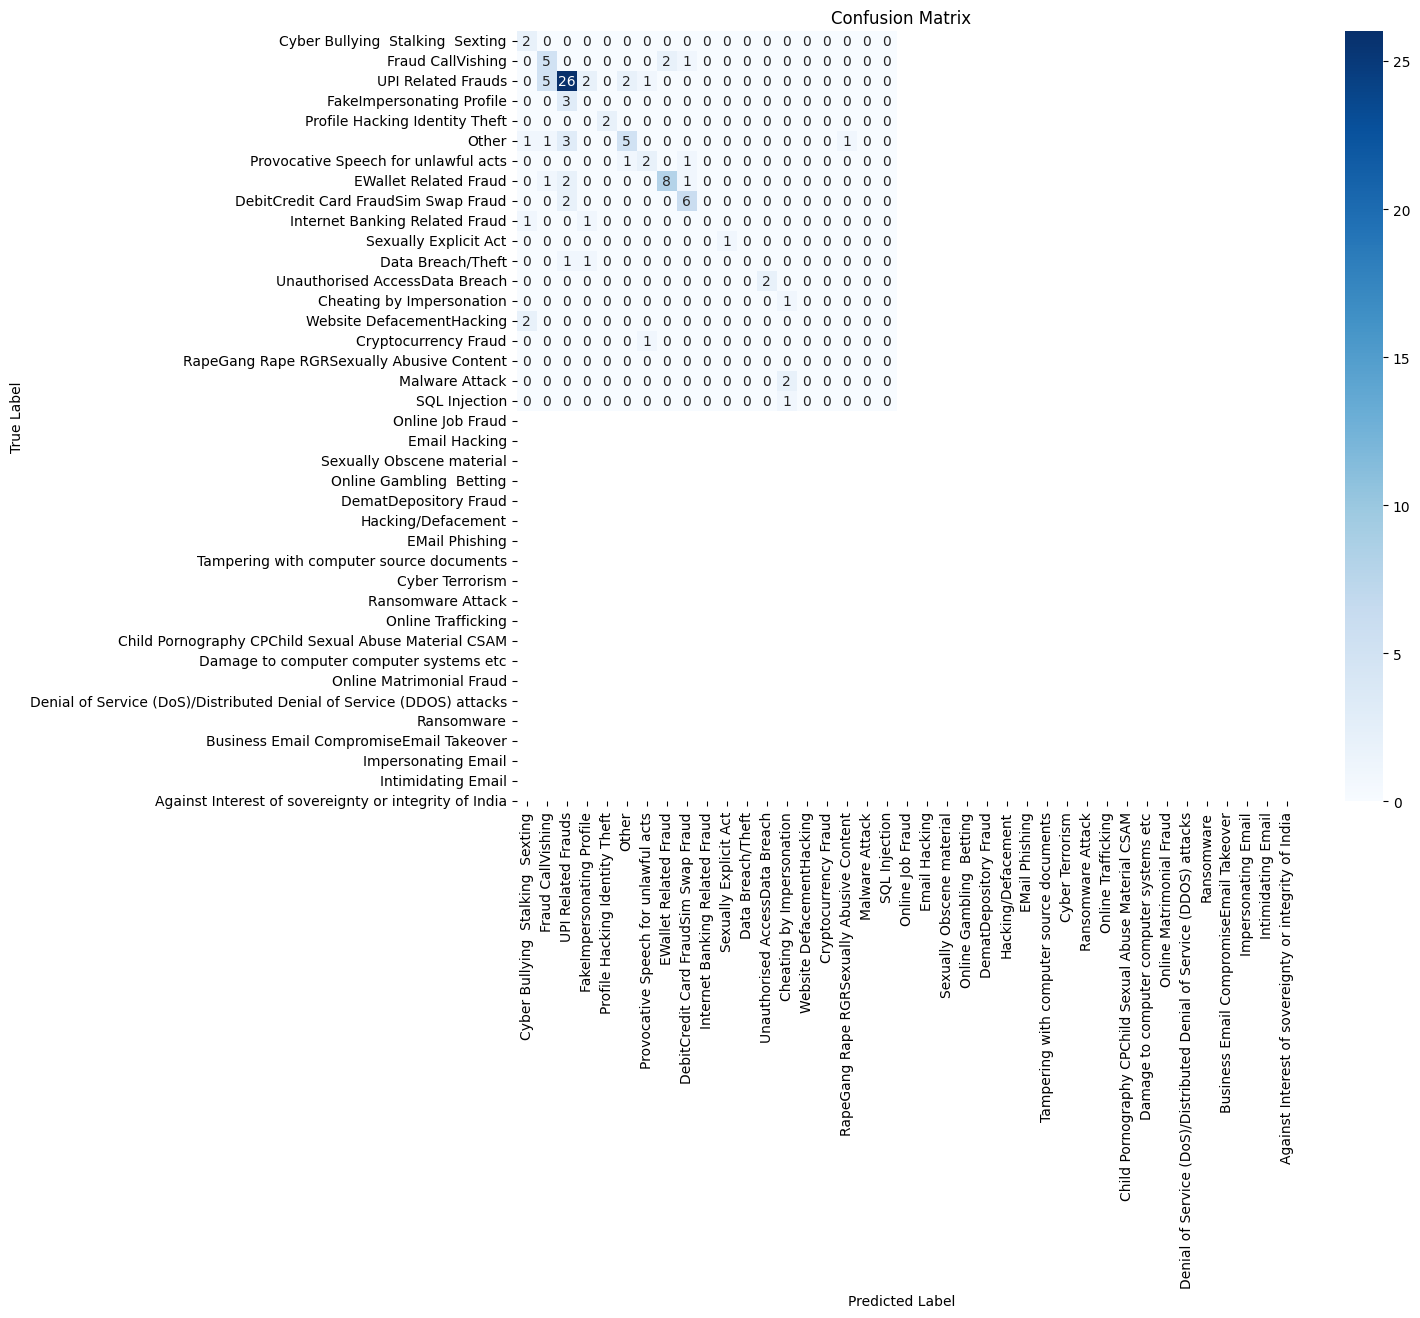

In [13]:
# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop over each row in the DataFrame with tqdm for progress tracking
for idx, row in tqdm(dft.iterrows(), total=len(dft), desc="Processing rows"):
    text = row['crimeaditionalinfo']
    actual_label = row['labels']
    processed_data = prepare_data(text, tokenizer)
    predicted_class = make_prediction(model, processed_data)
    
    # Store true and predicted labels
    y_true.append(actual_label)
    y_pred.append(predicted_class)  # Append single predicted class

    # if actual_label != predicted_class:
    #     print("Text:", text)
    #     print("Actual Label:", classes[actual_label])
    #     print("Predicted Label:", classes[predicted_class])
    #     print()

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

# Print the metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# Calculate confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(15, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(39)],
            yticklabels=[id2label[i] for i in range(39)],
            cbar=True, square=True)

plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()


In [14]:
text = 'upi'
processed_data = prepare_data(text, tokenizer)
predicted_class = make_prediction(model, processed_data)
print("Text:", text)
print("Predicted Label:", classes[predicted_class])

Text: upi
Predicted Label: UPI Related Frauds
